# YOLOv5 helmet detection

**The goal of this notebook is to explore method for object detection, concretly helmet detection, using YOLOv5 model.**

YOLOv5 (You only look once) 🚀 is a family of object detection architectures and models pretrained on the COCO dataset, and represents Ultralytics open-source research into future vision AI methods, incorporating lessons learned and best practices evolved over thousands of hours of research and development.


### References

* [Train] NFL Extra Images YOLOv5 with W&B - https://www.kaggle.com/ayuraj/train-nfl-extra-images-yolov5-with-w-b/ 
* YOLOv5 repository - https://github.com/ultralytics/yolov5
* NFL Helmet Assignment - Getting Started Guide - https://www.kaggle.com/robikscube/nfl-helmet-assignment-getting-started-guide
* MMDet CascadeRCNN helmet detection for beginners - https://www.kaggle.com/eneszvo/mmdet-cascadercnn-helmet-detection-for-beginners

### Setup

The structure that requires YOLOv5

```
/parent_folder
    /dataset
         /images
         /labels
    /yolov5
```

In [1]:
!mkdir tmp
%cd tmp/

/kaggle/working/tmp


In [2]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# Install dependencies
%pip install -qr requirements.txt  # install dependencies

%cd ../../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 14962, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 14962 (delta 13), reused 14 (delta 6), pack-reused 14936
Receiving objects: 100% (14962/14962), 13.95 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (10277/10277), done.
/kaggle/working/tmp/yolov5
Note: you may need to restart the kernel to use updated packages.
/kaggle/working
Setup complete. Using torch 1.11.0 (Tesla T4)


In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import Video, display
import subprocess
import shutil

In [4]:
os.makedirs('tmp/nfl_extra/images/all', exist_ok=True)

# base = "/kaggle/input/sordi-2022/test/images"
# os.listdir(base)
# for file in os.listdir(base):
#     copyfile(base+"/"+file, f'tmp/nfl_extra/images/all/{file}')
    
# base = "/kaggle/input/sordi-2022/valid/images"
# os.listdir(base)
# for file in os.listdir(base):
#     copyfile(base+"/"+file, f'tmp/nfl_extra/images/all/{file}')
    
base = "/kaggle/input/smartathon/images"
os.listdir(base)
for file in os.listdir(base):
    copyfile(base+"/"+file, f'tmp/nfl_extra/images/all/{file}')

In [5]:
TRAIN_PATH = 'tmp/nfl_extra/images/all'

In [6]:
print(f'Number of extra images: {len(os.listdir(TRAIN_PATH))}') 

Number of extra images: 9966


In [7]:
pd.read_csv('/kaggle/input/smartathon/train.csv')

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,797.0,701.0,262.0,211.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,932.0,786.0,329.0,238.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,736.0,657.0,275.0,229.0
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,986.0,786.0,136.0,0.0
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,667.0,549.0,228.0,179.0
...,...,...,...,...,...,...,...
19945,4.0,081e7bb3832ec5bb25276db161a96274.jpg,CONSTRUCTION_ROAD,1025.0,600.0,408.0,148.0
19946,2.0,1ff38a7af7f13b1201d17c6e1829373a.jpg,POTHOLES,657.0,418.0,364.0,282.0
19947,2.0,1ff38a7af7f13b1201d17c6e1829373a.jpg,POTHOLES,507.0,338.0,436.0,283.0
19948,7.0,ac97490f13140fc1bfe613ec69301b34.jpg,BAD_BILLBOARD,956.0,713.0,110.0,25.0


In [8]:
# Load image level csv file
# extra_df = pd.read_csv('/kaggle/input/pseudolabel/train_pseudo_label1280.csv')
extra_df = pd.read_csv('/kaggle/input/smartathon/train.csv')
extra_df.columns = ['ObjectClassId', 'path', 'ObjectClassName', 'Right', 'Left', 'Bottom', 'Top']
extra_df["Right"] = extra_df["Right"].apply(lambda x: int(x*2))
extra_df["Left"] = extra_df["Left"].apply(lambda x: int(x*2))
extra_df["Top"] = extra_df["Top"].apply(lambda x: int(x*2))
extra_df["Bottom"] = extra_df["Bottom"].apply(lambda x: int(x*2))
extra_df["Width"] = extra_df["Right"] - extra_df["Left"]
extra_df["Height"] = extra_df["Bottom"] - extra_df["Top"]

extra_df = extra_df[['ObjectClassName', 'ObjectClassId', 'Left', 'Top', 'Right',
       'Bottom', 'Width', 'Height', 'path']]
# extra_df[['Left', 'Top', 'Right', 'Bottom', 'Width', 'Height']] = extra_df[['Left', 'Top', 'Right', 'Bottom', 'Width', 'Height']]*2
# extra_df.path = extra_df.path.apply(lambda x: x+".jpg")
# indexAge = extra_df[ (extra_df['ObjectClassName'] == 'exit_sign')].index
# extra_df.drop(indexAge , inplace=True)
# indexAge = extra_df[ (extra_df['ObjectClassName'] == 'fire_extinguisher')].index
# extra_df.drop(indexAge , inplace=True)


extra_df["Right"] = extra_df["Right"] - extra_df["Width"]//4
extra_df["Left"] = extra_df["Left"] + extra_df["Width"]//4
extra_df["Top"] = extra_df["Top"] + extra_df["Height"]//4
extra_df["Bottom"] = extra_df["Bottom"] - extra_df["Height"]//4

extra_df = extra_df[extra_df["ObjectClassName"]=="POTHOLES"]

print('Number of ground truth bounding boxes: ', len(extra_df))

# Number of unique labels
label_to_id = {label: i for i, label in enumerate(extra_df.ObjectClassName.unique())}
print('Unique labels: ', label_to_id)

# Group together bbox coordinates belonging to the same image. 
# key is the name of the image, value is a dataframe with label and bbox coordinates. 
image_bbox_label = {} 
for image, df in extra_df.groupby('path'): 
    image_bbox_label[image] = df.reset_index(drop=True)

# # Visualize
extra_df.head()

Number of ground truth bounding boxes:  2625
Unique labels:  {'POTHOLES': 0}


,ObjectClassName,ObjectClassId,Left,Top,Right,Bottom,Width,Height,path
9,POTHOLES,2.0,1380,630,1582,754,402,248,e1f3026bc4b1689d81f03e92e9043c2b.jpg
14,POTHOLES,2.0,480,509,650,569,338,118,f05cd6411a3509a5ddc9d9a52536df01.jpg
34,POTHOLES,2.0,940,779,1174,1045,466,532,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
35,POTHOLES,2.0,1265,791,1465,1023,398,462,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
39,POTHOLES,2.0,1017,731,1537,945,1038,428,3fe43374bd1816998ad96704da640c60.jpg


In [9]:
extra_df.path.nunique()

1136

In [10]:
!ls

__notebook__.ipynb  tmp


In [11]:
extra_df.max()

ObjectClassName                                POTHOLES
ObjectClassId                                       2.0
Left                                               1788
Top                                                 991
Right                                              1914
Bottom                                             1074
Width                                              1592
Height                                              766
path               fff53b56bb409098e9d1efd05ceba7f0.jpg
dtype: object

In [12]:
i = extra_df["path"][35]
img = cv2.imread("tmp/nfl_extra/images/all/" + i)
group = extra_df.groupby("path")

group.get_group(i)



,ObjectClassName,ObjectClassId,Left,Top,Right,Bottom,Width,Height,path
34,POTHOLES,2.0,940,779,1174,1045,466,532,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
35,POTHOLES,2.0,1265,791,1465,1023,398,462,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg


In [13]:
i

'f6e45cdb24e1bfc3214308ff1ddd2de2.jpg'

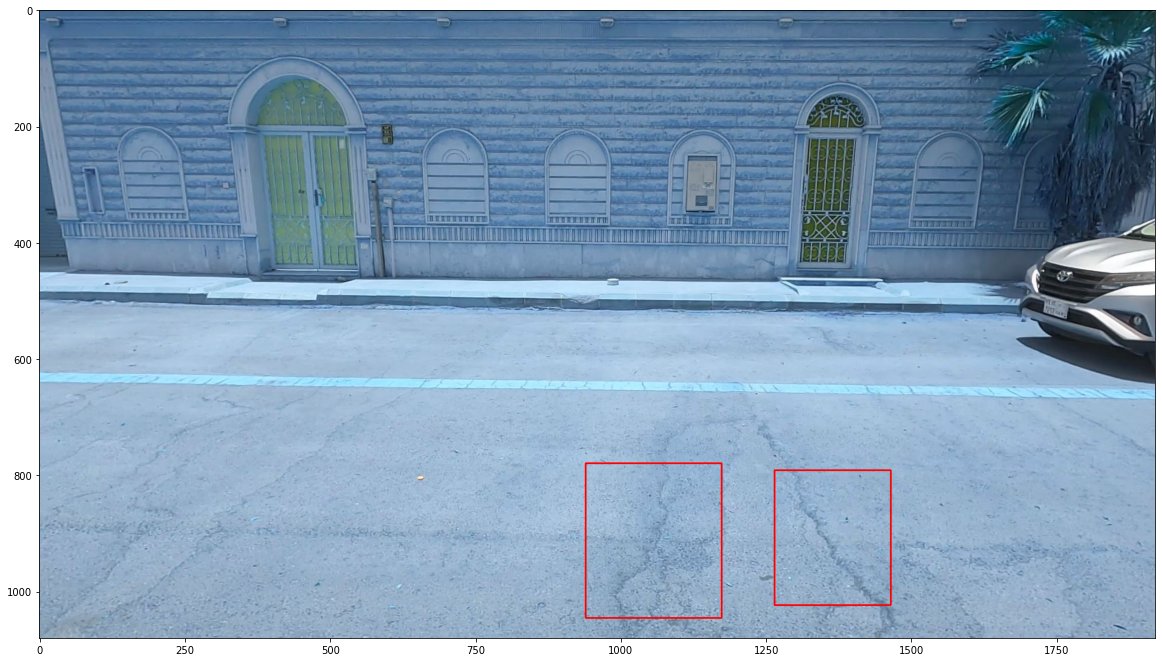

In [14]:
for idx, detect in group.get_group(i).iterrows():
    img = cv2.rectangle(img, (detect["Left"], detect["Top"]), (detect["Right"], detect["Bottom"]), (255,0,0), (2))
    

plt.figure(figsize=(20,40))
plt.imshow(img)

In [15]:
# image_bbox_label["bjh/1.jpg"]

In [16]:
!ls 

__notebook__.ipynb  tmp


In [17]:
# Create train and validation split.
train_names, valid_names = train_test_split(list(image_bbox_label), test_size=0.1)
print(f'Size of dataset: {len(image_bbox_label)},\
       training images: {len(train_names)},\
       validation images: {len(valid_names)}')

Size of dataset: 1136,       training images: 1022,       validation images: 114


In [18]:
for k in valid_names:
    if k.__contains__("bjh"):
        print("no")

In [19]:
os.makedirs('tmp/nfl_extra/images/train', exist_ok=True)
os.makedirs('tmp/nfl_extra/images/valid', exist_ok=True)

os.makedirs('tmp/nfl_extra/labels/train', exist_ok=True)
os.makedirs('tmp/nfl_extra/labels/valid', exist_ok=True)



# Move the images to relevant split folder.
for img_name in tqdm(train_names):
    img_name=img_name.split('/')[-1]
    copyfile(f'{TRAIN_PATH}/{img_name}',f'tmp/nfl_extra/images/train/{img_name}')

for img_name in tqdm(valid_names):
    img_name=img_name.split('/')[-1]
    copyfile(f'{TRAIN_PATH}/{img_name}',f'tmp/nfl_extra/images/valid/{img_name}')

100%|██████████| 114/114 [00:00<00:00, 2852.08it/s]


In [20]:
# len(os.listdir("tmp/nfl_extra/images/train"))

In [21]:
import yaml

data_yaml = dict(
    train = '../nfl_extra/images/train',
    val = '../nfl_extra/images/valid',
    nc = len(list(extra_df.ObjectClassName.unique())),
    names = list(extra_df.ObjectClassName.unique())
)

# Note that the file is created in the yolov5/data/ directory.
with open('tmp/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat tmp/yolov5/data/data.yaml

{names: [POTHOLES], nc: 1, train: ../nfl_extra/images/train, val: ../nfl_extra/images/valid}


In [22]:
# img.shape

In [23]:
def get_yolo_format_bbox(img_w, img_h, box):
    """
    Convert the bounding boxes in YOLO format.
    
    Input:
    img_w - Original/Scaled image width
    img_h - Original/Scaled image height
    box - Bounding box coordinates in the format, "left, width, top, height"
    
    Output:
    Return YOLO formatted bounding box coordinates, "x_center y_center width height".
    """
    w = box.Width # width 
    h = box.Height # height
    xc = box.Left + int(np.round(w/2)) # xmin + width/2
    yc = box.Top + int(np.round(h/2)) # ymin + height/2

    return [xc/img_w, yc/img_h, w/img_w, h/img_h] # x_center y_center width height
    
# Iterate over each image and write the labels and bbox coordinates to a .txt file. 

for img_name, df in tqdm(image_bbox_label.items()):
    # open image file to get the height and width 
    file=img_name
    img_name=img_name.split('/')[-1]
    img = cv2.imread("tmp/nfl_extra/images/all/"+img_name)
    height, width, _ = img.shape 
    # iterate over bounding box df
    bboxes = []
    for i in range(len(df)):
        # get a row
        box = df.loc[i]
        # get bbox in YOLO format
        box = get_yolo_format_bbox(width, height, box)
        bboxes.append(box)
    
    if file in train_names:
        img_name=img_name.split('/')[-1]
        img_name = img_name[:-4]
        file_name = f'tmp/nfl_extra/labels/train/{img_name}.txt'
    elif file in valid_names:
        img_name=img_name.split('/')[-1]
        img_name = img_name[:-4]
        file_name = f'tmp/nfl_extra/labels/valid/{img_name}.txt'  
    with open(file_name, 'w') as f:
        for i, bbox in enumerate(bboxes):
            label = label_to_id[df.loc[i].ObjectClassName]
            bbox = [label]+bbox
            bbox = [str(i) for i in bbox]
            bbox = ' '.join(bbox)
            f.write(bbox)
            f.write('\n')

100%|██████████| 1136/1136 [00:29<00:00, 38.05it/s]


In [24]:
%cd tmp/yolov5/

/kaggle/working/tmp/yolov5


In [25]:
# turn off W&B syncing if you don't need

os.environ['WANDB_MODE'] = 'offline'

In [26]:
!cat data/hyps/hyp.scratch-low.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.

In [27]:
!sed -i 's/scale: 0.5/scale: 0.0/g' data/hyps/hyp.scratch-low.yaml
# !sed -i 's/mosaic: 1.0/mosaic: 0.0/g' data/hyps/hyp.scratch-low.yaml
!sed -i 's/fliplr: 0.5/fliplr: 0.0/g' data/hyps/hyp.scratch-low.yaml
# !sed -i 's/lr0: 0.01/lr0: 0.003/g' data/hyps/hyp.scratch-low.yaml
# !sed -i 's/lrf: 0.01/lrf: 0.003/g' data/hyps/hyp.scratch-low.yaml

In [28]:
!cat data/hyps/hyp.scratch-low.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.

In [29]:
!python train.py --img 1280 \
                 --batch-size 12\
                 --epochs 15 \
                 --data data.yaml \
                 --weights yolov5l6.pt \
                 --save-period 5 \
                 --project nfl-extra

train: weights=yolov5l6.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=12, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=nfl-extra, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=5, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-63-gcdd804d Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0